 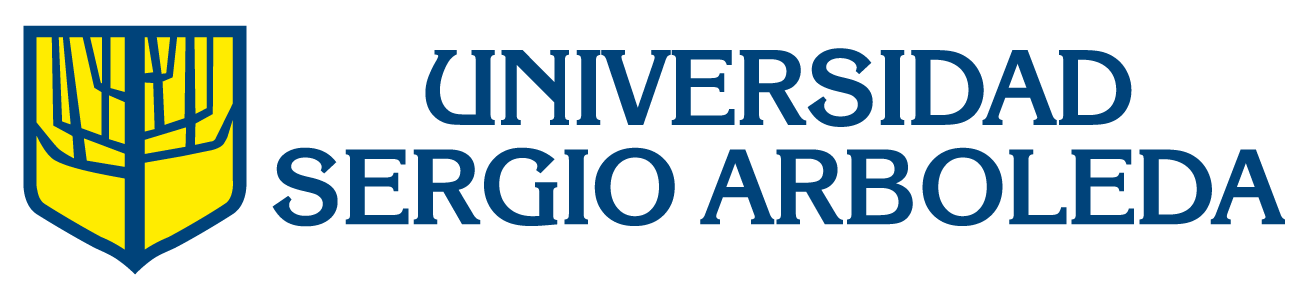
 **Modelos Neuronales** <br> 
**Carrera**:Ingenieria de Sistemas y Telecomunicaciones <br>
**Grupo**:Semillero Software como innovación <br>
**Autor**:Francisco Jose Rivera Gonzalez <br>
**Tutores**:John Jairo Corredor -- Camilo Enrique Rodriguez Torres <br>

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import os
import random

<h1 style="color:#9D00FF; font-family:Sans;">Fuente de datos : [Kaggle Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Datos_EMR/Training/'
test_dir = '/content/drive/MyDrive/Datos_EMR/Testing/'

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

<h1 style="color:#9D00FF; font-family:Sans;">Data Augmentation</h1>
<h3 style="font-size:15px; font-family:Sans; line-height: 1.7em;">
    <span style = "color : purple">Random Brightness : </span> 80% - 120%<br>
    <span style = "color : purple">Random Contrast : </span> 80% - 120% <br>
</h3>

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

<h3 style="font-family:Sans;">Imprimir ejemplos :</h3>

In [ ]:
IMAGE_SIZE = 250

In [ ]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

<h1 style="color:#9D00FF; font-family:Sans;">Data Generator</h1>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Dada una lista de rutas a las imágenes y las etiquetas de su clase, <br>
    esta función aumenta las imágenes, las normaliza, codifica la etiqueta y luego devuelve el lote que el modelo puede usar para entrenar.<br>
</p>

In [ ]:
unique_labels = os.listdir(train_dir)

In [ ]:
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [ ]:
def data_gen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

<h1 style="color:#9D00FF; font-family:Sans;">Estructura Modelo 1</h1>

In [ ]:
#Capas convolucionales
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())


#Capa completamente conectada
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 250)               6272250   
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1004      
                                                                 
Total params: 20,987,942
Trainable params: 13,352,678
No

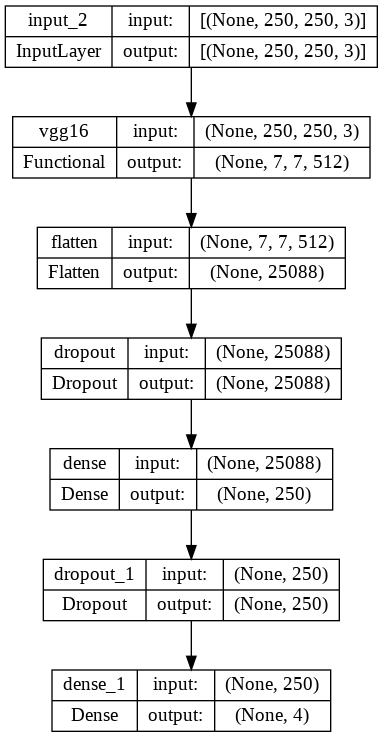

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

<h1 style="color:#9D00FF; font-family:Sans;">Entrenamiento Modelo 1</h1>

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history = model.fit(data_gen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 4574s 16s/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8512
Epoch 2/4
285/285 [==============================] - 4444s 16s/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9440
Epoch 3/4
115/285 [===========>..................] - ETA: 43:30 - loss: 0.1014 - sparse_categorical_accuracy: 0.9664

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

<h1 style="color:#9D00FF; font-family:Sans;">Evaluación Modelo 1

In [ ]:
batch_size=32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
        
    for i in decode_label(y):
        y_true.append(i)
        


In [ ]:
print(classification_report(y_true, y_pred))

<h1 style="color:#9D00FF; font-family:Sans;">Guardar Modelo 1 en formato TFLITE

In [ ]:
import numpy as np
from keras.preprocessing import image
from PIL import Image

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
model1_tflite = converter.convert()
with open('classifier_brain_tumor.tflite', 'wb') as f:
    f.write(model1_tflite)

<h1 style="color:#9D00FF; font-family:Sans;">Modelo 2</h1>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.metrics import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Datos_EMR/Training/'
test_dir = '/content/drive/MyDrive/Datos_EMR/Testing/'

<h1 style="color:#9D00FF; font-family:Sans;">Estructura</h1>


In [ ]:
model2 = Sequential()

#Capa convolucional 1
model2.add(Conv2D(32,(3,3), input_shape=(64, 64, 1), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

#Capa convolucional 2
model2.add(Conv2D(32,(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

#Capa completamente conectada

model2.add(Dense(units= 252, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=252, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy','Recall','Precision'])



# Se usa ImageDataGenerator para el preprocesamiento de las imagenes (Resize, Normalizacion , etc)

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False) 

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

# Crenado los 2 grupos de imagenes entrenamiento y pruebas

train = generator_train.flow_from_directory(data_dir, target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory(test_dir, target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

keras.utils.plot_model(model2, show_shapes=True)


<h1 style="color:#9D00FF; font-family:Sans;">Entrenamiento Modelo 2</h1>


In [ ]:
# Detener el modelo cuando el Loss deje de mejorar
model2_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model2_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Guardar los mejores pesos del modelo 
model2_mcp = ModelCheckpoint(filepath = 'model1_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

# Entrenamiento
history1 = model2.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model2_es, model2_rlr, model2_mcp])

<h1 style="color:#9D00FF; font-family:Sans;">Evaluación Modelo 2</h1>

In [ ]:
model2.evaluate(test)

In [ ]:
model2.summary()

<h1 style="color:#9D00FF; font-family:Sans;">Guardar Modelo 2 en formato TFLITE

In [ ]:
import numpy as np
from keras.preprocessing import image
from PIL import Image
converter=tf.lite.TFLiteConverter.from_keras_model(model2)
model2_tflite = converter.convert()
with open('classifier_brain_tumor_Model2.tflite', 'wb') as f:
    f.write(model2_tflite)

<H1 style="color:#9D00FF; font-family:Sans;">Modelo 3

In [ ]:
model3 = Sequential()

# Capa convolucional 1
model3.add(Conv2D(64,(7,7), input_shape=(200, 200, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

#Capa convolucional  2
model3.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

#Capa convolucional 3
model3.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

#Capa convolucional 4
model3.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

 #Capa convolucional  5
model3.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

#Capa convolucional 6
model3.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

# Capa completamente conectada
model3.add(Dense(units= 1024, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(units=4, activation='softmax'))



model3.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy','Recall','Precision'])

In [ ]:
# Preprocesamiento usando ImageDataGenerator

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train = generator_train.flow_from_directory(data_dir, target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory(test_dir, target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')
keras.utils.plot_model(model3, show_shapes=True)

<h1 style="color:#9D00FF; font-family:Sans;">Entrenamiento Modelo 3</h1>

In [ ]:
model3_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model3_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model3_mcp = ModelCheckpoint(filepath = 'model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history3 = model3.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model3_es, model3_rlr, model3_mcp])

<h1 style="color:#9D00FF; font-family:Sans;">Evaluación Modelo 3</h1>

In [ ]:
model3.evaluate(test)

In [ ]:
model3.summary()

<h1 style="color:#9D00FF; font-family:Sans;">Guardar Modelo 3 en formato TFLITE

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model3)
model3_tflite = converter.convert()
with open('classifier_brain_tumor_Model3.tflite', 'wb') as f:
    f.write(model3_tflite)